In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from os import listdir
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
from scipy.stats import ks_2samp, anderson_ksamp
from re import sub

In [2]:
# Colors for plots
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] #mpl default colors
cols = ['cyan', 'sandybrown', 'springgreen', 'tomato', 'mediumvioletred', 
        'peru', 'plum', 'silver', 'lemonchiffon', 'lightcyan'] #lighter than the defaults

#naming convention switch from our simulation data to paper convention
eq_to_plot = {
    'NE_NB_37' : 'NE_NB',
    'NE_NS_NB_37' : 'NE_NS_NB',
    'nNE_37' : 'nNE',
    'nNE_NS_37' : 'nNE_NS',
    'NE_37' : 'NE',
    'NE_NS_37' : 'NE_NS',
    'driver' : 'Driver',
    'follower' : 'Follower'
}

plot_37 = {
    'nNE_23' : 'nNE_23',
    'nNE_37' : 'nNE_37',
    'nNE_NS_23' : 'nNE_NS_23',
    'nNE_NS_37' : 'nNE_NS_37',
    'NE_23' : 'NE_23',
    'NE_37' : 'NE_37',
    'NE_NS_23' : 'NE_NS_23',
    'NE_NS_37' : 'NE_NS_37',
    'NE_NB_23' : 'NE_NB_23',
    'NE_NB_37' : 'NE_NB_37',
    'NE_NS_NB_23' : 'NE_NS_NB_23',
    'NE_NS_NB_37' : 'NE_NS_NB_37',
}
    
pull_to_plot = {
    'nNE_pull16_fine_37' : 'nNE',
    'nNE_NS_pull16_fine_37' : 'nNE_NS',
    'NE_pull16_fine_37' : 'NE',
    'NE_NS_pull16_fine_37' : 'NE_NS',
    'driver_pull16_fine' : 'Driver',
    'follower_pull16_fine' : 'Follower'
}

pull_37 = {
    'nNE_pull16_fine_23' : 'nNE_23',
    'nNE_pull16_fine_37' : 'nNE_37',
    'nNE_NS_pull16_fine_23' : 'nNE_NS_23',
    'nNE_NS_pull16_fine_37' : 'nNE_NS_37',
    'NE_pull16_fine_same_start_23': 'NE_23',
    'NE_pull16_fine_37' : 'NE_37',
    'NE_NS_pull16_fine_23' : 'NE_NS_23',
    'NE_NS_pull16_fine_37' : 'NE_NS_37'
}

release_to_plot = {
    'nNE_release_fine_37' : 'nNE',
    'nNE_NS_release_fine_37' : 'nNE_NS',
    'NE_NB_release_fine_37' : 'NE_NB',
    'NE_NS_NB_release_fine_37' : 'NE_NS_NB',
    'NE_release_fine_37' : 'NE',
    'NE_NS_release_fine_37' : 'NE_NS',
    'driver_release_fine' : 'Driver',
    'follower_release_fine' : 'Follower',
    'driver_NB_release_fine' : 'Driver_NB',
    'follower_NB_release_fine' : 'Follower_NB'
}

release_37 = {
    'nNE_release_fine_23' : 'nNE_23',
    'nNE_release_fine_37' : 'nNE_37',
    'nNE_NS_release_fine_23' : 'nNE_NS_23',
    'nNE_NS_release_fine_37' : 'nNE_NS_37',
    'NE_release_fine_same_start_23': 'NE_23',
    'NE_release_fine_37' : 'NE_37',
    'NE_NS_release_fine_23' : 'NE_NS_23',
    'NE_NS_release_fine_37' : 'NE_NS_37',
    'NE_NB_release_fine_23' : 'NE_NB_23',
    'NE_NB_release_fine_37' : 'NE_NB_37',
    'NE_NS_NB_release_fine_23' : 'NE_NS_NB_23',
    'NE_NS_NB_release_fine_37' : 'NE_NS_NB_37'
}

df_to_plot = {
    'driver' : 'Driver',
    'follower' : 'Follower'
}

df_pull = {
    'driver_pull16_fine' : 'Driver',
    'follower_pull16_fine' : 'Follower'
}

df_release = {
    'driver_release_fine' : 'Driver',
    'follower_release_fine' : 'Follower',
    'driver_NB_release_fine' : 'Driver_NB',
    'follower_NB_release_fine' : 'Follower_NB'
}

colormap = {
    'nNE' : cols[0],
    'nNE_NS' : cols[1],
    'NE_NB' : cols[2],
    'NE_NS_NB' : cols[3],
    'NE' : cols[4],
    'NE_NS' : cols[5],
    'NE_from_nNE_start' : cols[6],
    'nNE_23' : cols[0],
    'nNE_NS_23' : cols[1],
    'NE_23' : cols[4],
    'NE_NS_23' : cols[5],
    'nNE_37' : colors[0],
    'nNE_NS_37' : colors[1],
    'NE_37' : colors[4],
    'NE_NS_37' : colors[5],
    'NE_NB_23' : cols[2],
    'NE_NB_37' : cols[2],
    'NE_NS_NB_23' : cols[3],
    'NE_NS_NB_37' : cols[3],
    'Driver' : cols[6],
    'Follower' : cols[7],
    'Driver_NB' : cols[8],
    'Follower_NB' : cols[9]
}

In [3]:
#Plotting helper functions
def get_timestep(data_file, lengths):
    if 'fine' in  data_file:
        return([np.linspace(0, n*5000*0.003, num=n, endpoint=True) for n in lengths])
    else:
        return([np.linspace(0, n*500000*0.003, num=n, endpoint=True) for n in lengths])
    
def make_plot(axs, times, data, i, name):
    x = int(np.floor(i/len(axs[0])))
    y = i%len(axs[0])
    for i, (t, d) in enumerate(zip(times, data)):
        axs[x][y].plot(t, d, alpha=0.4, c=cols[i])
        
    axs[x][y].set_ylim((0, 120))
    axs[x][y].set_title(name)
    axs[x][y].spines['right'].set_visible(False)
    axs[x][y].spines['top'].set_visible(False)
    axs[x][y].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
    
def get_rate(axs, times, data, i):
    x = int(np.floor(i/len(axs[0])))
    y = i%len(axs[0])
    
    
    rates = []
    r2s = []
    for j, (t, d) in enumerate(zip(times, data)):
        t = t.reshape(-1, 1)
        d = d.reshape(-1, 1)
        regressor = LinearRegression()
        results = regressor.fit(t, d)
        model = results.predict
        r2 = r2_score(d, model(t))
        
        rates.append(results.coef_[0][0] / 3.03 / 0.001)
        r2s.append(r2)
        
        axs[x][y].plot(t, model(t), c=colors[j])
        
    return(rates, r2s)

#returns all pairwise significances
get_significance_ks = lambda d : [ks_2samp(a, b, mode='asymp')[1] for a in d for b in d]

#significance annotations (From https://stackoverflow.com/questions/11517986/indicating-the-statistically-significant-difference-in-bar-graph)
#Did not end up using
def sig_brackets(ax, num1, num2, data, center, height, yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None):
    """ 
    Annotate barplot with p-values.

    :param ax: the axis to add the annotation to
    :param num1: number of left bar to put bracket over
    :param num2: number of right bar to put bracket over
    :param data: string to write or number for generating asterixes
    :param center: centers of all bars (like plt.bar() input)
    :param height: heights of all bars (like plt.bar() input)
    :param yerr: yerrs of all bars (like plt.bar() input)
    :param dh: height offset over bar / bar + yerr in axes coordinates (0 to 1)
    :param barh: bar height in axes coordinates (0 to 1)
    :param fs: font size
    :param maxasterix: maximum number of asterixes to write (for very small p-values)
    """

    if type(data) is str:
        text = data
    else:
        # * is p < 0.05
        # ** is p < 0.005
        # *** is p < 0.0005
        # etc.
        text = ''
        p = .05

        while data < p:
            text += '*'
            p /= 10.

            if maxasterix and len(text) == maxasterix:
                break

        if len(text) == 0:
            text = 'n. s.'

    lx, ly = center[num1], height[num1]
    rx, ry = center[num2], height[num2]

    if yerr:
        ly += yerr[num1]
        ry += yerr[num2]

    ax_y0, ax_y1 = plt.gca().get_ylim()
    dh *= (ax_y1 - ax_y0)
    barh *= (ax_y1 - ax_y0)

    y = max(ly, ry) + dh

    barx = [lx, lx, rx, rx]
    bary = [y, y+barh, y+barh, y]
    mid = ((lx+rx)/2, y+barh)

    ax.plot(barx, bary, c='black')

    kwargs = dict(ha='center', va='bottom')
    if fs is not None:
        kwargs['fontsize'] = fs

    ax.text(*mid, text, **kwargs)

In [5]:
# Extract all data files into Pandas data frame
df = pd.DataFrame()

files = listdir('../data/')
files.sort()

for i, data_file in enumerate(files):
    with open('../data/'+data_file) as f:
        lines = [line for line in f.readlines() if line.strip()] #remove trailing blank line
        data = [np.array(line.strip().split(), dtype=float) for line in lines]
        
        
        #make_plot(axs, times, data, i)
        
        mean = [np.mean(d) for d in data]
        variance = [np.var(d) for d in data]
        k = [0.5/v for v in variance]
        start = [np.mean(l[0:10]) for l in data]
        end = [np.mean(l[-10:-1]) for l in data]
        rates = [0 for _ in data] 
        r2s = [0 for _ in data] #get_rate(axs, times, data, i)
        autocorrelation = [sm.tsa.acf(d, nlags=2000, fft=True) for d in data]

        
    
        
        cleaned_name = sub('.txt|data','',data_file).strip('_')

        s = pd.Series({
            'mean' : mean,
            'variance' : variance,
            'k' : k,
            'start' : start,
            'end' : end,
            'rate' : rates,
            'r2' : r2s,
            'autocor' : autocorrelation,
            'data' : data
        }, name=cleaned_name)
        
        df = pd.concat((df, s), axis=1)

/home/erik/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':
/home/erik/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))


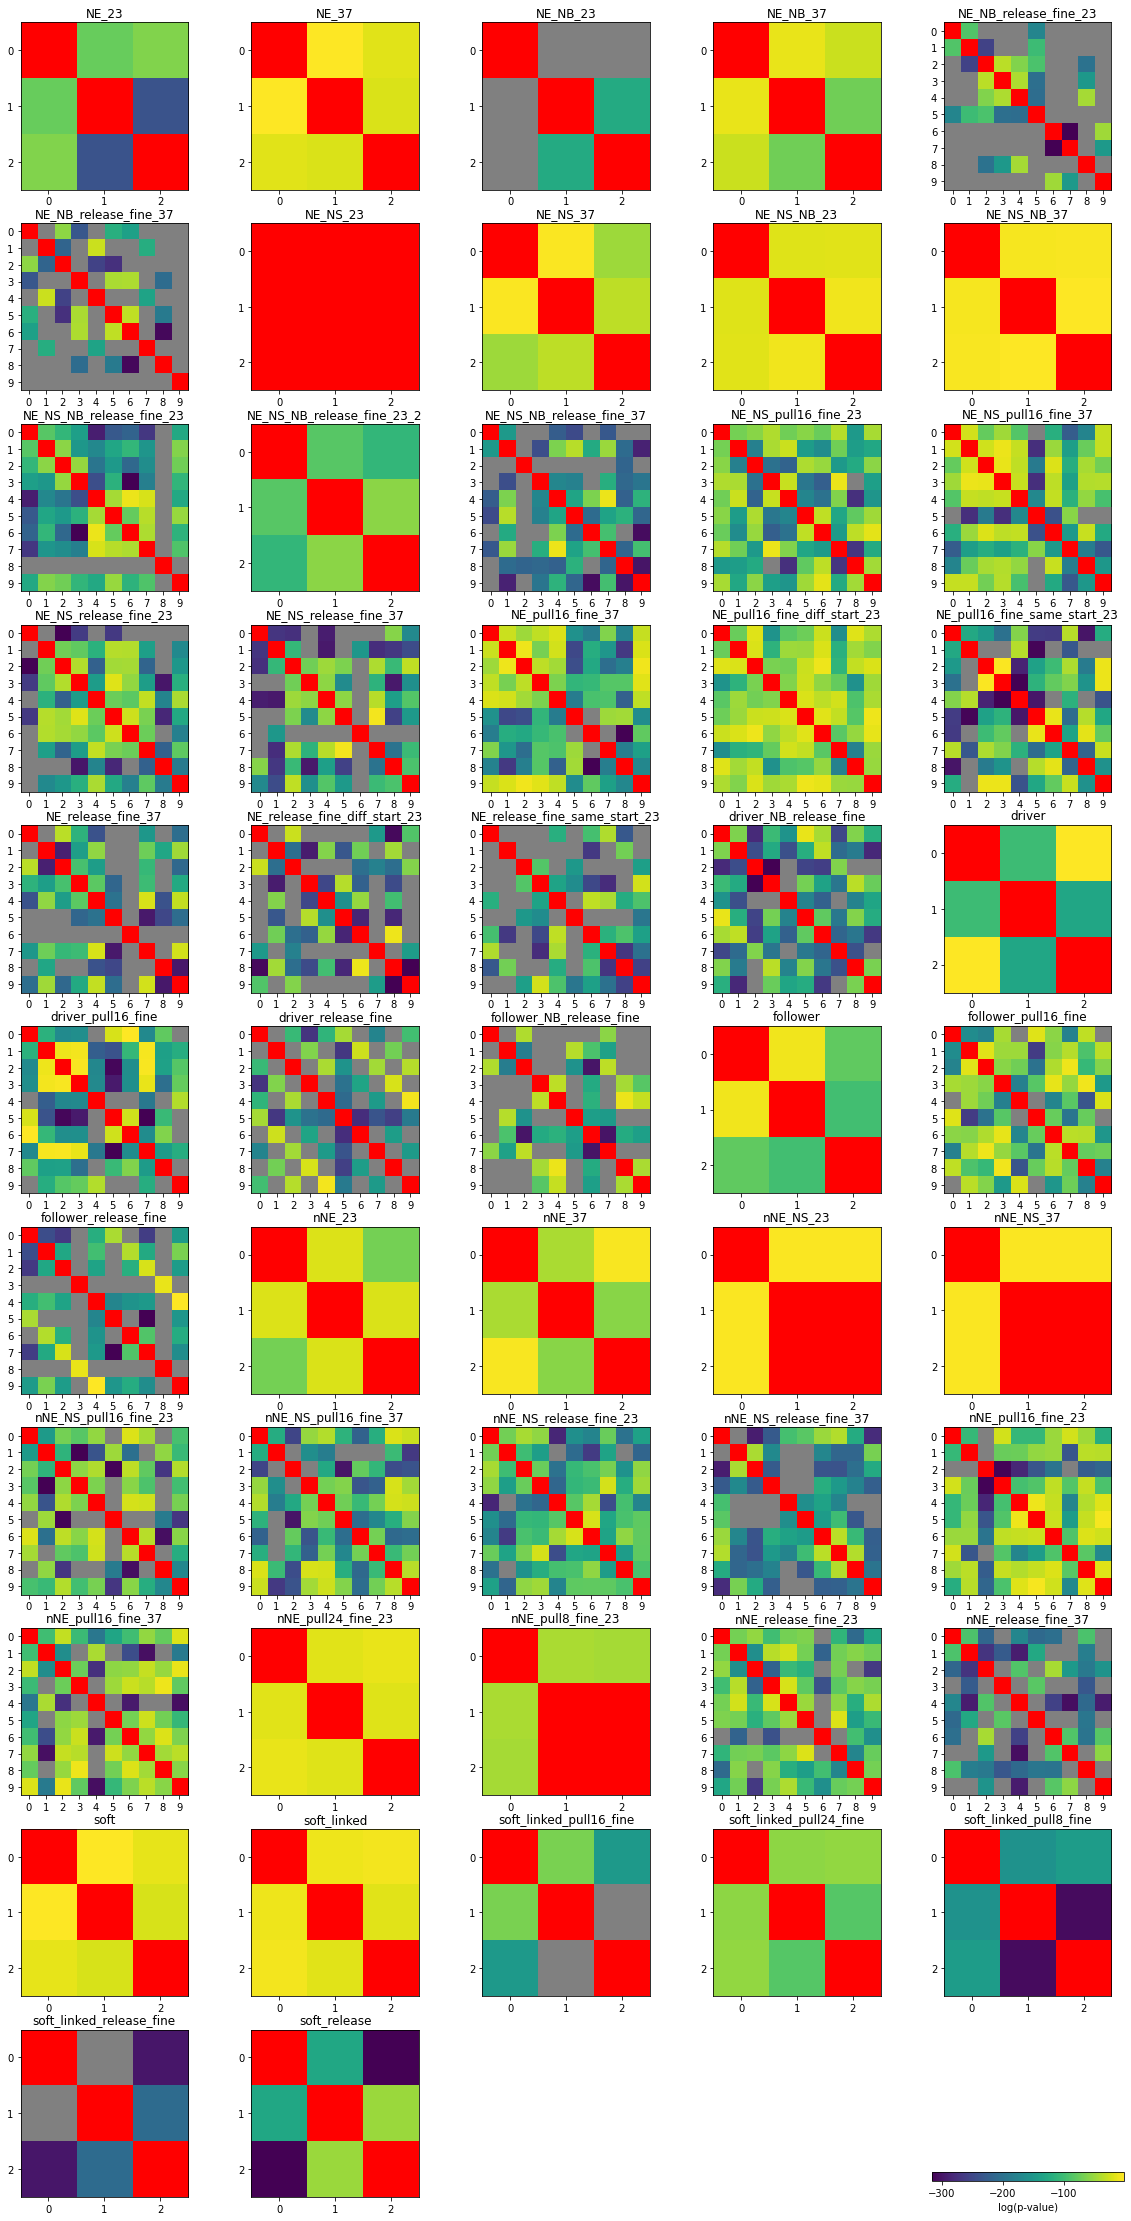

In [6]:
# Determine if all simulations of the same structure are statistically the same
get_significance = lambda d : [ks_2samp(a, b, mode='asymp')[1] for a in d for b in d]

# Need to get color bounds before making the plots
sigs = []
names = []
maxs = []
mins = []
for d in df:
    sig = get_significance(df[d]['data'])
    l = int(np.sqrt(len(sig)))
    sig = np.log10(np.array(sig)).reshape(l, l)
    
    sigs.append(sig)
    names.append(d)
    maxs.append(np.max(sig))
    mins.append(np.min(sig))

all_min = min([m for m in mins if m > -400]) #
all_max = -2 #-1.30103 #log(0.05)
    
fig, axs = plt.subplots(11, 5, figsize=(20, 40)) #52 plots
cmap = mpl.cm.viridis
cmap.set_over(color='red')
for i, (d, n) in enumerate(zip(sigs, names)):
    x = int(np.floor(i/len(axs[0])))
    y = i%len(axs[0])
    
    l = d[0].size
    d_mask = np.ma.array(d, mask=np.isinf(d)) #values with too big of significance are grey
    axs[x][y].imshow(d_mask, vmin=all_min, vmax=all_max, cmap=cmap)
    axs[x][y].set_xticks(np.arange(l))
    axs[x][y].set_yticks(np.arange(l))
    axs[x][y].set_title(n)
    axs[x][y].set_facecolor('grey')
    
norm = mpl.colors.Normalize(all_min, all_max)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), orientation='horizontal', label='log(p-value)')

axs[10][2].set_axis_off()
axs[10][3].set_axis_off()
axs[10][4].set_axis_off()
     


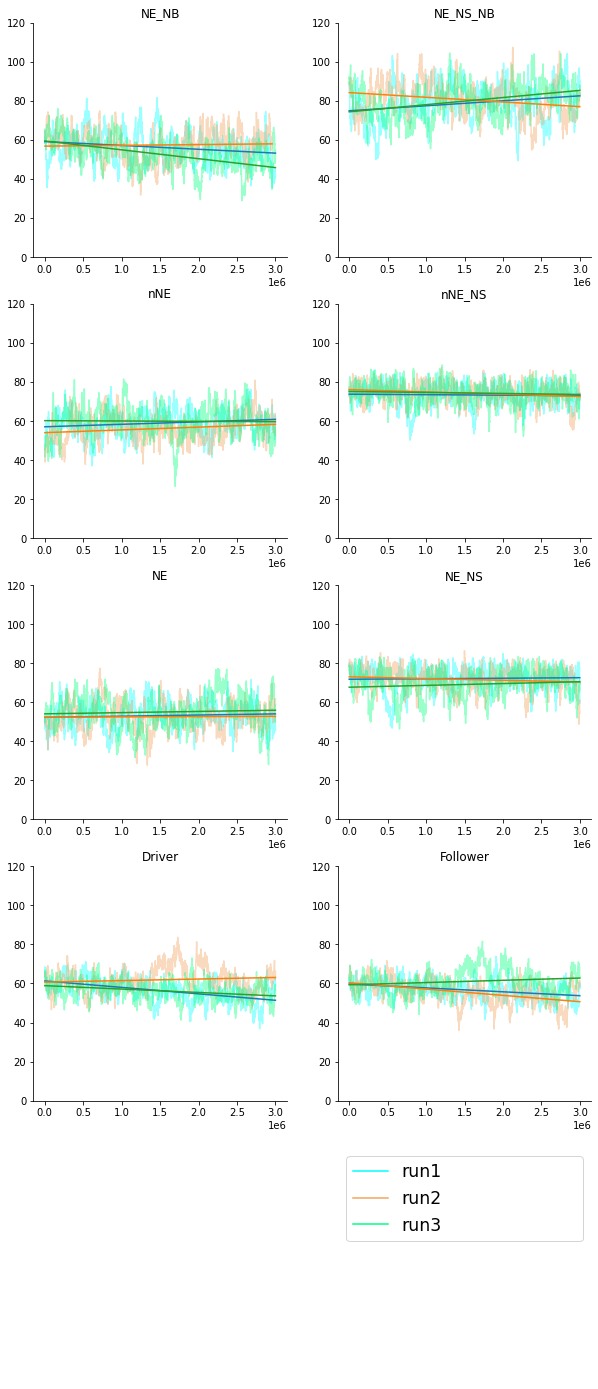

In [7]:
#plot equilibrium data
fig, axs = plt.subplots(5,2, figsize=(10,25)) #there are 8 plots in groups of 2
for i, d in enumerate(eq_to_plot.keys()):
    name = eq_to_plot[d]
    data = df[d]['data']
    times = get_timestep(d, map(len, data))
    make_plot(axs, times, data, i, name)
    rates, r2 = get_rate(axs, times, data, i)
    df[d]['rate'] = rates
    df[d]['r2'] = r2

for i in range(3):
    axs[4][1].plot(1, 1, label='run{}'.format(i+1), c=cols[i])
    axs[4][1].legend(mode='expand', fontsize='xx-large')
    axs[4][1].set_axis_off()
    
axs[4][0].set_axis_off()

plt.savefig('../final_plots/equilibrium_trajectory.png', dpi=600)

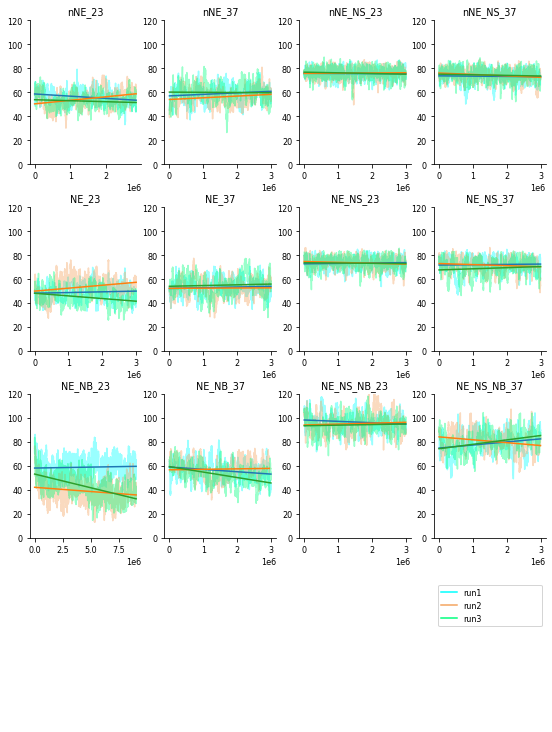

In [8]:
#plot equilibrium 37 deg data
plt.rcParams.update({'font.size': 8})
fig, axs = plt.subplots(4,4, figsize=(7.5,10)) #there are 10 plots in groups of 2
for i, d in enumerate(plot_37.keys()):
    name = plot_37[d]
    data = df[d]['data']
    times = get_timestep(d, map(len, data))
    make_plot(axs, times, data, i, name)
    rates, r2 = get_rate(axs, times, data, i)
    df[d]['rate'] = rates
    df[d]['r2'] = r2

for i in range(3):
    axs[3][3].plot(1, 1, label='run{}'.format(i+1), c=cols[i])
    axs[3][3].legend(mode='expand')
    axs[3][3].set_axis_off()
    
axs[3][0].set_axis_off()
axs[3][1].set_axis_off()
axs[3][2].set_axis_off()

#make it fit better
plt.tight_layout(pad=0.1)

plt.savefig('../final_plots/equilibrium_37.png', dpi=600)

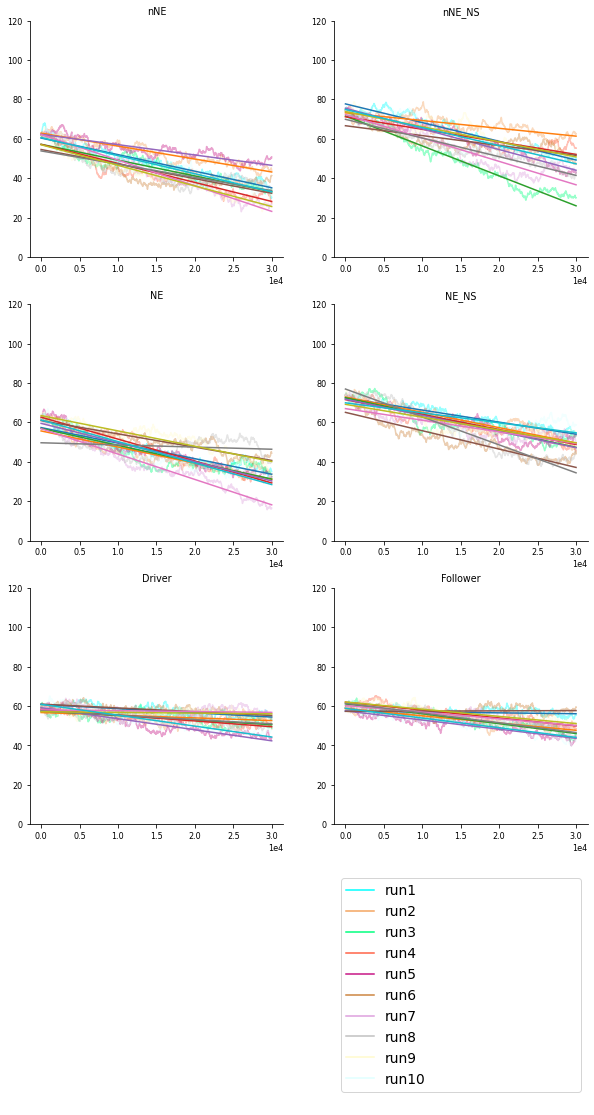

In [9]:
#plot pull data
fig, axs = plt.subplots(4,2, figsize=(10,20)) #there are 6 plots in groups of 2
for i, d in enumerate(pull_to_plot.keys()):
    if 'stiff' in d:
        i = i+1
    name = pull_to_plot[d]
    data = df[d]['data']
    times = get_timestep(d, map(len, data))
    make_plot(axs, times, data, i, name)
    rates, r2 = get_rate(axs, times, data, i)
    df[d]['rate'] = rates
    df[d]['r2'] = r2

for i in range(10):
    axs[3][1].plot(1, 1, label='run{}'.format(i+1), c=cols[i])
    axs[3][1].legend(mode='expand', fontsize='xx-large')
    axs[3][1].set_axis_off()
    
axs[3][0].set_axis_off()

plt.savefig('../final_plots/pull_trajectory.png', dpi=600)

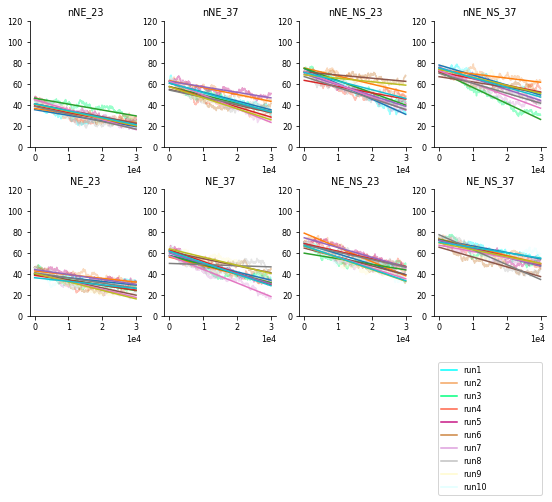

In [10]:
#plot pull 37 deg data
plt.rcParams.update({'font.size': 8})
fig, axs = plt.subplots(3,4, figsize=(7.5,7)) #there are 8 plots in groups of 2
for i, d in enumerate(pull_37.keys()):
    name = pull_37[d]
    data = df[d]['data']
    times = get_timestep(d, map(len, data))
    make_plot(axs, times, data, i, name)
    rates, r2 = get_rate(axs, times, data, i)
    df[d]['rate'] = rates
    df[d]['r2'] = r2

for i in range(10):
    axs[2][3].plot(1, 1, label='run{}'.format(i+1), c=cols[i])
    axs[2][3].legend(mode='expand')
    axs[2][3].set_axis_off()
    
axs[2][0].set_axis_off()
axs[2][1].set_axis_off()
axs[2][2].set_axis_off()

#make it fit better
plt.tight_layout(pad=0.1)

plt.savefig('../final_plots/pull_37.png', dpi=600)

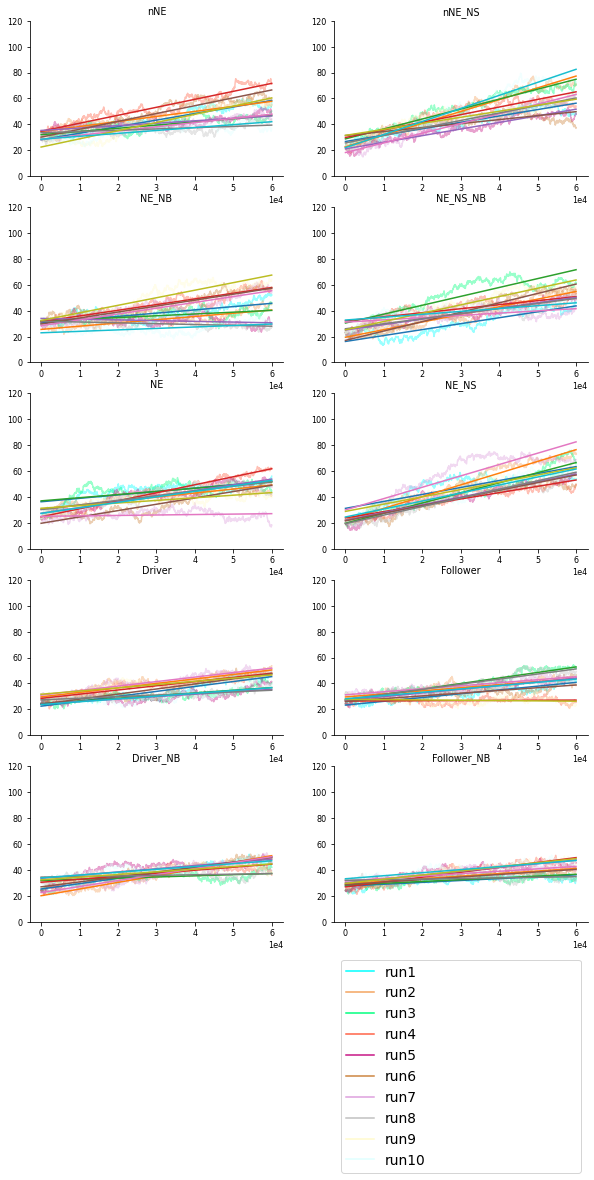

In [11]:
#plot release data
fig, axs = plt.subplots(6,2, figsize=(10,20)) #there are 10 plots in groups of 2
for i, d in enumerate(release_to_plot.keys()):
    name = release_to_plot[d]
    data = df[d]['data']
    times = get_timestep(d, map(len, data))
    make_plot(axs, times, data, i, name)
    rates, r2 = get_rate(axs, times, data, i)
    df[d]['rate'] = rates
    df[d]['r2'] = r2

for i in range(10):
    axs[5][1].plot(1, 1, label='run{}'.format(i+1), c=cols[i])
    axs[5][1].legend(mode='expand', fontsize='xx-large')
    axs[5][1].set_axis_off()
    
axs[5][0].set_axis_off()

plt.savefig('../final_plots/release_trajectory.png', dpi=600)

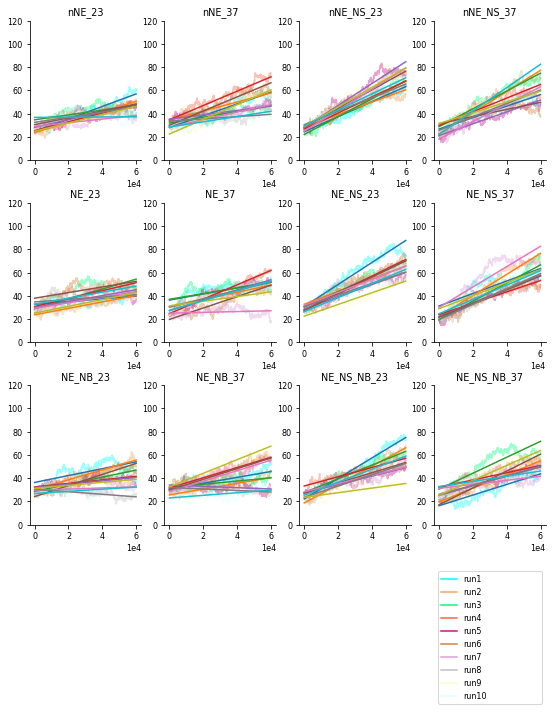

In [48]:
#plot release data
plt.rcParams.update({'font.size': 8})
fig, axs = plt.subplots(4,4, figsize=(7.5,10)) #there are 12 plots in groups of 2
for i, d in enumerate(release_37.keys()):
    name = release_37[d]
    data = df[d]['data']
    times = get_timestep(d, map(len, data))
    make_plot(axs, times, data, i, name)
    rates, r2 = get_rate(axs, times, data, i)
    df[d]['rate'] = rates
    df[d]['r2'] = r2

for i in range(10):
    axs[3][3].plot(1, 1, label='run{}'.format(i+1), c=cols[i])
    axs[3][3].legend(mode='expand')
    axs[3][3].set_axis_off()
    
[a.set_axis_off() for a in axs[-1][0:-1]]
#axs[3][0].set_axis_off()
#axs[3][1].set_axis_off()
#axs[3][2].set_axis_off()

#make it fit better
plt.tight_layout(pad=0.1)

plt.savefig('../final_plots/release_compare.png', dpi=600)

In [13]:
df

,NE_23,NE_37,NE_NB_23,NE_NB_37,NE_NB_release_fine_23,NE_NB_release_fine_37,NE_NS_23,NE_NS_37,NE_NS_NB_23,NE_NS_NB_37,...,nNE_pull8_fine_23,nNE_release_fine_23,nNE_release_fine_37,soft,soft_linked,soft_linked_pull16_fine,soft_linked_pull24_fine,soft_linked_pull8_fine,soft_linked_release_fine,soft_release
mean,"[49.1866166515884, 53.745964127829126, 44.9854...","[53.18227281203293, 52.59681347159998, 55.0178...","[59.00781803781132, 39.06787001184566, 42.9694...","[56.21214251628561, 57.42035361691056, 52.6680...","[45.13687460043258, 42.790632023667875, 37.721...","[38.071216157085416, 32.99673851224143, 36.053...","[73.33220509434756, 73.65667785969194, 73.3716...","[72.19849552707939, 71.7218796762872, 69.13434...","[96.64442161880332, 95.30285418661553, 94.2916...","[78.76849085264821, 80.66119549425925, 79.8965...",...,"[28.1636955525338, 27.01457708001556, 27.00840...","[40.74044034656054, 37.06411386453541, 40.9590...","[43.21774666235668, 46.04451102406485, 39.3793...","[35.90753770012507, 36.391578098442004, 34.147...","[46.67104490200813, 47.94325974721214, 45.4952...","[20.883187762777247, 17.077032452206936, 25.17...","[31.965523745245466, 31.381225423420226, 32.42...","[41.851068592657626, 39.110954088430546, 45.25...","[23.243262208581324, 32.020354757527166, 28.38...","[24.520358805882033, 20.34412406024102, 19.774..."
variance,"[41.86875352235056, 62.030616636990956, 43.900...","[43.826738282857576, 50.69132052824998, 70.902...","[52.22694363749877, 70.9221892972975, 90.90926...","[60.270349343739774, 55.77998192815735, 62.889...","[68.23516912861928, 59.47523181426782, 33.0546...","[36.335915157794325, 28.25113476167686, 16.920...","[20.25977331169753, 20.812548536143105, 24.765...","[36.75951515252699, 31.563564086875253, 44.464...","[49.47679542048918, 71.69495460419203, 48.7429...","[88.33427408898325, 66.6286103242641, 70.17564...",...,"[40.617452456989255, 55.285622559566136, 54.03...","[93.52614336204903, 64.55409150466072, 40.7991...","[84.66486070266863, 52.86288079753473, 28.7958...","[77.18684921504786, 110.22425776558808, 62.706...","[77.52313356607547, 58.1793084598825, 66.73224...","[36.30087560175206, 39.33220514550587, 20.7632...","[169.846086621655, 268.53460039414193, 95.4060...","[36.910542481113715, 75.6386693060389, 20.7020...","[36.13510228969085, 144.6586335882968, 49.0278...","[71.55934845025072, 25.785007776863328, 16.691..."
k,"[0.011942079902930185, 0.008060535701684982, 0...","[0.011408560609119532, 0.009863621519217533, 0...","[0.009573602534937574, 0.007049979772960175, 0...","[0.00829595324142475, 0.008963789207461242, 0....","[0.007327599629122768, 0.008406860885577119, 0...","[0.013760490077893256, 0.017698404124929467, 0...","[0.024679446917173126, 0.024023967998522584, 0...","[0.013601920425918027, 0.015841050098898996, 0...","[0.010105747467083155, 0.006973991444172904, 0...","[0.005660317075751668, 0.00750428378389749, 0....",...,"[0.012309979325499584, 0.009043942653649007, 0...","[0.005346098770099502, 0.007745442439754584, 0...","[0.00590563777995137, 0.009458432693348744, 0....","[0.00647778740918632, 0.00453620654959039, 0.0...","[0.0064496876867578355, 0.008594120714665672, ...","[0.013773772442443991, 0.012712229028357197, 0...","[0.002943841744872155, 0.001861957450794514, 0...","[0.013546265277890148, 0.006610375414947716, 0...","[0.013836960969186112, 0.003456413126526664, 0...","[0.006987207273800271, 0.019391113019118257, 0..."
start,"[48.35159689066751, 53.365443371025606, 55.195...","[49.663313424842855, 49.46062764060612, 53.463...","[77.00087538072464, 72.93986496506894, 79.3178...","[59.99049178944574, 61.42761950848795, 60.2611...","[27.99753072415063, 26.940256179646827, 27.759...","[31.045126855344897, 30.16133445550391, 29.944...","[77.70053524716475, 76.17750043235989, 77.6927...","[75.66296364551621, 78.22207725290014, 76.8326...","[106.41318384897599, 104.36861264290341, 104.4...","[80.33593100142124, 88.5491139493599, 91.31787...",...,"[44.318918576669

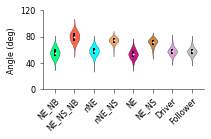

In [14]:
#Violin plots of equilibriums

#end of whiskers: q1 and a3 +/- (q3-q1)*1.5
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])
    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value

#set up plots
plt.rcParams.update({'font.size': 8})
vfig, vax = plt.subplots(figsize=(2.756, 1.757))

#extract the data in the correct format for a violin plot
munge_zone = []
for i, d in enumerate(eq_to_plot.keys()):
    munge2 = []
    for j in range(3):
        munge2.append(df[d]['data'][j])
    munge_zone.append(np.concatenate(munge2).ravel())
    munge_zone[-1].sort()

#make violin plots
parts = vax.violinplot(munge_zone, showmeans=False, showmedians=False,
        showextrema=False)

#change body colors and add outline
for pc, d in zip(parts['bodies'], eq_to_plot.keys()):
    pc.set(color=colormap[eq_to_plot[d]])
    pc.set_edgecolor('black')
    pc.set_linewidth(0.25)
    pc.set_alpha(1)
    
#calculate internal lines
quartile1 = []
medians = []
quartile3 = []
for d in munge_zone:
    q1, m, q3 = np.percentile(d, [25, 50, 75])
    quartile1.append(q1)
    medians.append(m)
    quartile3.append(q3)
    
whiskers = np.array([
    adjacent_values(sorted_array, q1, q3) for sorted_array, q1, q3 in zip(munge_zone, quartile1, quartile3)])
whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

#add median markers and internal lines to plot
inds = np.arange(1, len(medians) + 1)
vax.scatter(inds, medians, marker='o', color='white', s=1, zorder=3) #medians marked by white dots
vax.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=2) #quartiles marked by thick black rectangle
#vax.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1) #whiskers
    
#set axes labels
vax.set_ylabel('Angle (deg)')
plt.xticks(np.linspace(1, len(eq_to_plot.keys()), len(eq_to_plot.keys())), labels=[eq_to_plot[d] for d in eq_to_plot.keys()], rotation=45, ha="right", rotation_mode="anchor")
plt.yticks(np.linspace(0, 120, 4))

#get significance between distributions
#sigs = np.array(get_significance_ks(munge_zone))

#significance bars
#sigs = sigs.reshape(len(munge_zone), len(munge_zone))
#for i in range(len(munge_zone)):
#    for j in range(i+1, len(munge_zone)):
#        if sigs[i][j] < 0.05:
#            print(i, j, sigs[i][j])
#            sig_brackets(vax, i, j, sigs[i][j], np.linspace(1, len(eq_to_plot.keys()), len(eq_to_plot.keys())), [max(m) for m in munge_zone], barh=0.05*j, maxasterix=3)

#The largest significance is 6.9e-38 between NE_NB and NE

#make pretty by setting spine and tick widths
vax.spines['top'].set_visible(False)
vax.spines['right'].set_visible(False)
vax.spines['left'].set_linewidth(0.5)
vax.spines['bottom'].set_linewidth(0.5)
vax.xaxis.set_tick_params(width=0.5)
vax.yaxis.set_tick_params(width=0.5)
    
#make it fit better
plt.tight_layout(pad=0.1)
    
#save the figure
plt.savefig('../final_plots/equilibrium_violin.png', dpi=600)

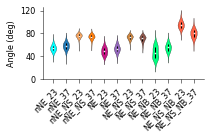

In [15]:
#Violin plots comparing 23 to 37 at equilibrium

#set up plots
plt.rcParams.update({'font.size': 8})
vfig, vax = plt.subplots(figsize=(2.756, 1.757))

#extract the data in the correct format for a violin plot
munge_zone = []
for i, d in enumerate(plot_37.keys()):
    munge2 = []
    for j in range(3):
        munge2.append(df[d]['data'][j])
    munge_zone.append(np.concatenate(munge2).ravel())
    munge_zone[-1].sort()
            
#make violin plots
parts = vax.violinplot(munge_zone, showmeans=False, showmedians=False,
        showextrema=False)

#change body colors and add outline
for pc, d in zip(parts['bodies'], plot_37.keys()):
    pc.set(color=colormap[plot_37[d]])
    pc.set_edgecolor('black')
    pc.set_linewidth(0.25)
    pc.set_alpha(1)
    
#calculate internal lines
quartile1 = []
medians = []
quartile3 = []
for d in munge_zone:
    q1, m, q3 = np.percentile(d, [25, 50, 75])
    quartile1.append(q1)
    medians.append(m)
    quartile3.append(q3)
    
whiskers = np.array([
    adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(munge_zone, quartile1, quartile3)])
whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

#add median markers and internal lines to plot
inds = np.arange(1, len(medians) + 1)
vax.scatter(inds, medians, marker='o', color='white', s=0.4, zorder=3) #medians marked by white dots
vax.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=1) #quartiles marked by thick black rectangle
#vax.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1) #whiskers
    
#set axes labels
vax.set_ylabel('Angle (deg)')
plt.xticks(np.linspace(1, len(plot_37.keys()), len(plot_37.keys())), labels=[plot_37[d] for d in plot_37.keys()], rotation=45, ha="right", rotation_mode="anchor")
plt.yticks(np.linspace(0, 120, 4))

#get significance between distributions
#sigs = np.array(get_significance_ks(munge_zone))

#significance bars
#sigs = sigs.reshape(len(munge_zone), len(munge_zone))
#for i in range(len(munge_zone)):
#    for j in range(i+1, len(munge_zone)):
#        if sigs[i][j] < 0.05:
#            print(i, j, sigs[i][j])
#            sig_brackets(vax, i, j, sigs[i][j], np.linspace(1, len(plot_37.keys()), len(plot_37.keys())), [max(m) for m in munge_zone], barh=0.05*j, maxasterix=3)

#The largest significance is 3.7e-14 between nNE_NS_37 and NE_NS_23 and

#make pretty by setting spine and tick widths
vax.spines['top'].set_visible(False)
vax.spines['right'].set_visible(False)
vax.spines['left'].set_linewidth(0.5)
vax.spines['bottom'].set_linewidth(0.5)
vax.xaxis.set_tick_params(width=0.5)
vax.yaxis.set_tick_params(width=0.5)
    
#make it fit better
plt.tight_layout(pad=0.1)
    
#save the figure
plt.savefig('../final_plots/t_compare_violin.png', dpi=600)

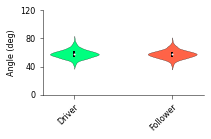

In [16]:
#Violin plots of driver_follower at equilibrium

#end of whiskers: q1 and a3 +/- (q3-q1)*1.5
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])
    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value

#set up plots
plt.rcParams.update({'font.size': 8})
vfig, vax = plt.subplots(figsize=(2.756, 1.757))

#extract the data in the correct format for a violin plot
munge_zone = []
for i, d in enumerate(df_to_plot.keys()):
    munge2 = []
    for j in range(3):
        munge2.append(df[d]['data'][j])
    munge_zone.append(np.concatenate(munge2).ravel())
    munge_zone[-1].sort()

#make violin plots
parts = vax.violinplot(munge_zone, showmeans=False, showmedians=False,
        showextrema=False)

#change body colors and add outline
for pc, d in zip(parts['bodies'], eq_to_plot.keys()):
    pc.set(color=colormap[eq_to_plot[d]])
    pc.set_edgecolor('black')
    pc.set_linewidth(0.25)
    pc.set_alpha(1)
    
#calculate internal lines
quartile1 = []
medians = []
quartile3 = []
for d in munge_zone:
    q1, m, q3 = np.percentile(d, [25, 50, 75])
    quartile1.append(q1)
    medians.append(m)
    quartile3.append(q3)
    
whiskers = np.array([
    adjacent_values(sorted_array, q1, q3) for sorted_array, q1, q3 in zip(munge_zone, quartile1, quartile3)])
whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

#add median markers and internal lines to plot
inds = np.arange(1, len(medians) + 1)
vax.scatter(inds, medians, marker='o', color='white', s=1, zorder=3) #medians marked by white dots
vax.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=2) #quartiles marked by thick black rectangle
#vax.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1) #whiskers
    
#set axes labels
vax.set_ylabel('Angle (deg)')
plt.xticks(np.linspace(1, len(df_to_plot.keys()), len(df_to_plot.keys())), labels=[df_to_plot[d] for d in df_to_plot.keys()], rotation=45, ha="right", rotation_mode="anchor")
plt.yticks(np.linspace(0, 120, 4))

#get significance between distributions
#sigs = np.array(get_significance_ks(munge_zone))

#significance bars
#sigs = sigs.reshape(len(munge_zone), len(munge_zone))
#for i in range(len(munge_zone)):
#    for j in range(i+1, len(munge_zone)):
#        if sigs[i][j] < 0.05:
#            print(i, j, sigs[i][j])
#            sig_brackets(vax, i, j, sigs[i][j], np.linspace(1, len(eq_to_plot.keys()), len(eq_to_plot.keys())), [max(m) for m in munge_zone], barh=0.05*j, maxasterix=3)

#The largest significance is 6.9e-38 between NE_NB and NE

#make pretty by setting spine and tick widths
vax.spines['top'].set_visible(False)
vax.spines['right'].set_visible(False)
vax.spines['left'].set_linewidth(0.5)
vax.spines['bottom'].set_linewidth(0.5)
vax.xaxis.set_tick_params(width=0.5)
vax.yaxis.set_tick_params(width=0.5)
    
#make it fit better
plt.tight_layout(pad=0.1)
    
#save the figure
plt.savefig('../final_plots/df_violin.png', dpi=600)

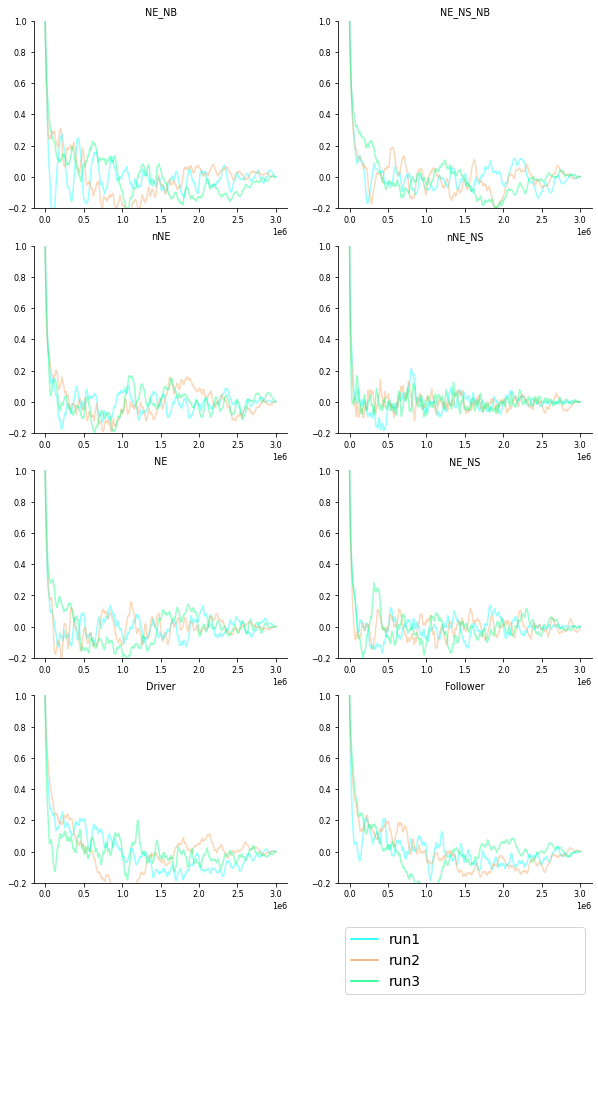

In [17]:
#plot equilibrium decorrelation
fig, axs = plt.subplots(5,2, figsize=(10,20)) #there are 8 plots in groups of 2
for i, d in enumerate(eq_to_plot.keys()):
    name = eq_to_plot[d]
    data = df[d]['autocor']
    times = get_timestep(d, map(len, data))
    make_plot(axs, times, data, i, name)
    
for a in axs.flatten():
    a.set_ylim((-0.2, 1))

for i in range(3):
    axs[4][1].plot(1, 1, label='run{}'.format(i+1), c=cols[i])
    axs[4][1].legend(mode='expand', fontsize='xx-large')
    axs[4][1].set_axis_off()
    
axs[4][0].set_axis_off()

plt.savefig('../final_plots/equilibrium_autocor.png', dpi=600)

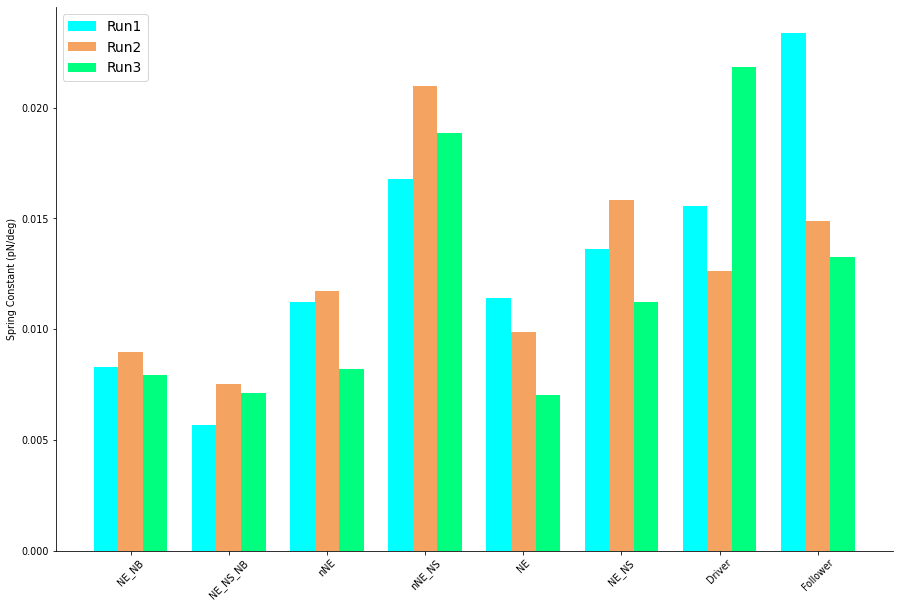

In [18]:
x = np.arange(len(eq_to_plot.keys()))
width = 0.25
fig, ax = plt.subplots(figsize=(15, 10))
run1s = [d[0] for d in df.loc['k', list(eq_to_plot.keys())]]
run2s = [d[1] for d in df.loc['k', list(eq_to_plot.keys())]]
run3s = [d[2] for d in df.loc['k', list(eq_to_plot.keys())]]

rects1 = ax.bar(x - width, run1s, width, label='Run1', color=cols[0])
rects2 = ax.bar(x , run2s, width, label='Run2', color=cols[1])
rects3 = ax.bar(x + width, run3s, width, label='Run3', color=cols[2])

ax.set_ylabel('Spring Constant (pN/deg)', fontsize='large')
ax.set_xticks(x)
ax.set_xticklabels([eq_to_plot[d] for d in eq_to_plot.keys()], rotation=45, fontsize='large')
plt.setp(ax.get_yticklabels(), fontsize='large')
ax.legend(fontsize='xx-large')    
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
    
plt.savefig('../final_plots/equilibrium_k.png', dpi=600)

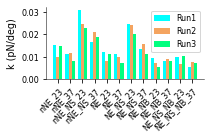

In [19]:
x = np.arange(len(plot_37.keys()))
width = 0.25
plt.rcParams.update({'font.size': 8})
fig, ax = plt.subplots(figsize=(2.756, 1.757))#figsize=(15, 10))
run1s = [d[0] for d in df.loc['k', list(plot_37.keys())]]
run2s = [d[1] for d in df.loc['k', list(plot_37.keys())]]
run3s = [d[2] for d in df.loc['k', list(plot_37.keys())]]

rects1 = ax.bar(x - width, run1s, width, label='Run1', color=cols[0])
rects2 = ax.bar(x , run2s, width, label='Run2', color=cols[1])
rects3 = ax.bar(x + width, run3s, width, label='Run3', color=cols[2])

ax.set_ylabel('k (pN/deg)', fontsize='large')
ax.set_xticks(x)
plt.xticks(np.linspace(0, len(plot_37.keys())-1, len(plot_37.keys())), labels=[plot_37[d] for d in plot_37.keys()], rotation=45, ha="right", rotation_mode="anchor")
ax.legend()  

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)
plt.tight_layout(pad=0.1)
    
plt.savefig('../final_plots/equilibrium_k.png', dpi=600)

In [20]:
def make_boxes(namedict):
    
    plt.rcParams.update({'font.size': 8})
    bfig, bax = plt.subplots(figsize=(2.362, 1.650))
    
    munge_zone = []
    for i, d in enumerate(namedict.keys()):
        munge_zone.append(df[d]['rate'])
        
    if 'pull' in list(namedict.keys())[0]:
        munge_zone = [-np.array(d) for d in munge_zone]
        
    box_props = dict(linewidth=0.5)
    median_props = dict(color="black",linewidth=0.5)
    outlier_props = dict(markerfacecolor='k', marker='o', markersize=0.5)

    bplot = bax.boxplot(munge_zone, patch_artist=True, boxprops=box_props, whiskerprops=box_props, capprops=box_props, flierprops=outlier_props, medianprops=median_props)
    for patch, c in zip(bplot['boxes'], [colormap[namedict[d]] for d in namedict.keys()]):
        patch.set_facecolor(c)
        
        
    bax.set_ylabel('Rate (deg/ns)')
    plt.xticks(np.linspace(1, len(namedict.keys()), len(namedict.keys())), labels=[namedict[d] for d in namedict.keys()], rotation=45, ha="right", rotation_mode="anchor")

    
    #get significance between distributions
    sigs = np.array(get_significance_ks(munge_zone))

    #significance bars
    sigs = sigs.reshape(len(munge_zone), len(munge_zone))
    for i in range(len(munge_zone)):
        for j in range(i+1, len(munge_zone)):
                if sigs[i][j] < 1 and sigs[i][j] > 0.05:
                    print(list(namedict.keys())[i], "-", list(namedict.keys())[j], "is not significant")
                else:
                    print(list(namedict.keys())[i], "-", list(namedict.keys())[j], "is SIGNIFICANT")
                          

    #The largest significance is 3.7e-14 between nNE_NS_37 and NE_NS_23 and
    
    #make pretty by setting spine and tick widths
    bax.spines['top'].set_visible(False)
    bax.spines['right'].set_visible(False)
    bax.spines['left'].set_linewidth(0.5)
    bax.spines['bottom'].set_linewidth(0.5)
    bax.xaxis.set_tick_params(width=0.5)
    bax.yaxis.set_tick_params(width=0.5)
    

nNE_pull16_fine_37 - nNE_NS_pull16_fine_37 is not significant
nNE_pull16_fine_37 - NE_pull16_fine_37 is not significant
nNE_pull16_fine_37 - NE_NS_pull16_fine_37 is not significant
nNE_pull16_fine_37 - driver_pull16_fine is SIGNIFICANT
nNE_pull16_fine_37 - follower_pull16_fine is SIGNIFICANT
nNE_NS_pull16_fine_37 - NE_pull16_fine_37 is not significant
nNE_NS_pull16_fine_37 - NE_NS_pull16_fine_37 is not significant
nNE_NS_pull16_fine_37 - driver_pull16_fine is SIGNIFICANT
nNE_NS_pull16_fine_37 - follower_pull16_fine is SIGNIFICANT
NE_pull16_fine_37 - NE_NS_pull16_fine_37 is not significant
NE_pull16_fine_37 - driver_pull16_fine is SIGNIFICANT
NE_pull16_fine_37 - follower_pull16_fine is SIGNIFICANT
NE_NS_pull16_fine_37 - driver_pull16_fine is SIGNIFICANT
NE_NS_pull16_fine_37 - follower_pull16_fine is SIGNIFICANT
driver_pull16_fine - follower_pull16_fine is SIGNIFICANT


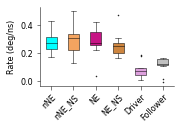

In [21]:
make_boxes(pull_to_plot)
plt.tight_layout(pad=0.2)
plt.savefig('../final_plots/pull_rate.png', dpi=600)

#None of these differences are significant.

nNE_pull16_fine_23 - nNE_pull16_fine_37 is SIGNIFICANT
nNE_pull16_fine_23 - nNE_NS_pull16_fine_23 is SIGNIFICANT
nNE_pull16_fine_23 - nNE_NS_pull16_fine_37 is SIGNIFICANT
nNE_pull16_fine_23 - NE_pull16_fine_same_start_23 is SIGNIFICANT
nNE_pull16_fine_23 - NE_pull16_fine_37 is SIGNIFICANT
nNE_pull16_fine_23 - NE_NS_pull16_fine_23 is SIGNIFICANT
nNE_pull16_fine_23 - NE_NS_pull16_fine_37 is not significant
nNE_pull16_fine_37 - nNE_NS_pull16_fine_23 is not significant
nNE_pull16_fine_37 - nNE_NS_pull16_fine_37 is not significant
nNE_pull16_fine_37 - NE_pull16_fine_same_start_23 is SIGNIFICANT
nNE_pull16_fine_37 - NE_pull16_fine_37 is not significant
nNE_pull16_fine_37 - NE_NS_pull16_fine_23 is not significant
nNE_pull16_fine_37 - NE_NS_pull16_fine_37 is not significant
nNE_NS_pull16_fine_23 - nNE_NS_pull16_fine_37 is not significant
nNE_NS_pull16_fine_23 - NE_pull16_fine_same_start_23 is SIGNIFICANT
nNE_NS_pull16_fine_23 - NE_pull16_fine_37 is not significant
nNE_NS_pull16_fine_23 - NE_NS

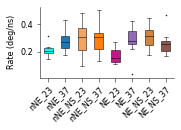

In [22]:
make_boxes(pull_37)
plt.tight_layout(pad=0.2)
plt.savefig('../final_plots/pull_37_rate.png', dpi=600)

nNE_release_fine_37 - nNE_NS_release_fine_37 is not significant
nNE_release_fine_37 - NE_NB_release_fine_37 is not significant
nNE_release_fine_37 - NE_NS_NB_release_fine_37 is not significant
nNE_release_fine_37 - NE_release_fine_37 is not significant
nNE_release_fine_37 - NE_NS_release_fine_37 is SIGNIFICANT
nNE_release_fine_37 - driver_release_fine is not significant
nNE_release_fine_37 - follower_release_fine is not significant
nNE_release_fine_37 - driver_NB_release_fine is not significant
nNE_release_fine_37 - follower_NB_release_fine is not significant
nNE_NS_release_fine_37 - NE_NB_release_fine_37 is SIGNIFICANT
nNE_NS_release_fine_37 - NE_NS_NB_release_fine_37 is not significant
nNE_NS_release_fine_37 - NE_release_fine_37 is SIGNIFICANT
nNE_NS_release_fine_37 - NE_NS_release_fine_37 is not significant
nNE_NS_release_fine_37 - driver_release_fine is SIGNIFICANT
nNE_NS_release_fine_37 - follower_release_fine is SIGNIFICANT
nNE_NS_release_fine_37 - driver_NB_release_fine is SIGNI

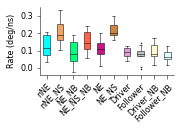

In [23]:
make_boxes(release_to_plot)
plt.tight_layout(pad=0.2)
plt.savefig('../final_plots/release_rate.png', dpi=600)

nNE_release_fine_23 - nNE_release_fine_37 is not significant
nNE_release_fine_23 - nNE_NS_release_fine_23 is SIGNIFICANT
nNE_release_fine_23 - nNE_NS_release_fine_37 is SIGNIFICANT
nNE_release_fine_23 - NE_release_fine_same_start_23 is not significant
nNE_release_fine_23 - NE_release_fine_37 is not significant
nNE_release_fine_23 - NE_NS_release_fine_23 is SIGNIFICANT
nNE_release_fine_23 - NE_NS_release_fine_37 is SIGNIFICANT
nNE_release_fine_23 - NE_NB_release_fine_23 is not significant
nNE_release_fine_23 - NE_NB_release_fine_37 is not significant
nNE_release_fine_23 - NE_NS_NB_release_fine_23 is not significant
nNE_release_fine_23 - NE_NS_NB_release_fine_37 is not significant
nNE_release_fine_37 - nNE_NS_release_fine_23 is SIGNIFICANT
nNE_release_fine_37 - nNE_NS_release_fine_37 is not significant
nNE_release_fine_37 - NE_release_fine_same_start_23 is not significant
nNE_release_fine_37 - NE_release_fine_37 is not significant
nNE_release_fine_37 - NE_NS_release_fine_23 is SIGNIFICAN

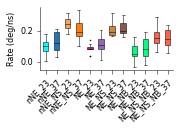

In [24]:
make_boxes(release_37)
plt.tight_layout(pad=0.2)
plt.savefig('../final_plots/release_37_rate.png', dpi=600)

/home/erik/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/erik/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/erik/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/home/erik/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/home/erik/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/erik/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/erik/anaconda3/lib/python3.7/site-packages/numpy/core/_met

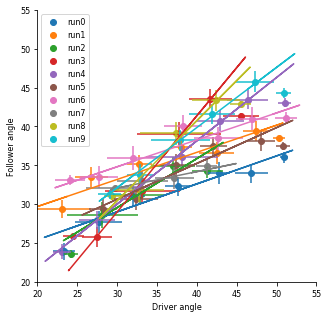

In [25]:
# Plot driver vs follower angles
fig, ax = plt.subplots(figsize=(5,5))

for i, (d, f) in enumerate(zip(df['driver_NB_release_fine']['data'], df['follower_NB_release_fine']['data'])):
    bins = np.arange(20, 65, 5)
    bounds = [(bins[i], bins[i+1]) for i in range(len(bins)-1)]
    d_binned = [d[np.logical_and(d>i, d<=j)] for i, j in bounds]
    f_binned = [f[np.logical_and(d>i, d<=j)] for i, j in bounds]
    means_d = [np.mean(x) for x in d_binned]
    means_f = [np.mean(y) for y in f_binned]
    stdev_d = [np.std(x) for x in d_binned]
    stdev_f = [np.std(y) for y in f_binned]
    
    ax.scatter(means_d, means_f, label='run{}'.format(i))
    ax.errorbar(means_d, means_f, stdev_d, stdev_f, fmt='none')
    
    d = d.reshape(-1, 1)
    f = f.reshape(-1, 1)
    regressor = LinearRegression()
    results = regressor.fit(d, f)
    model = results.predict
    r2 = r2_score(f, model(d))
    
    #ax.scatter(d, f, alpha=0.3)
    ax.plot(d, model(d), c=colors[i])
               
ax.set_xlabel('Driver angle')
ax.set_ylabel('Follower angle')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim((20, 55))
ax.set_ylim((20, 55))
plt.legend()

/home/erik/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/erik/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/erik/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/home/erik/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/home/erik/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.03171447065867705
0.40856957044342157
0.0482371927364601
0.45262788964369516


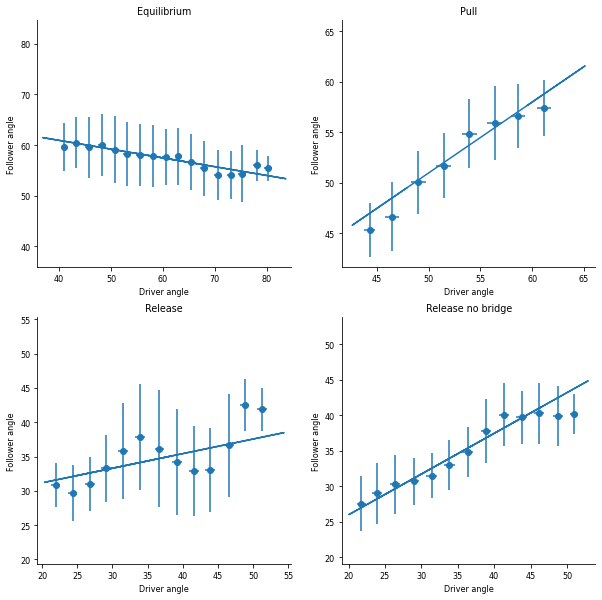

In [26]:
def plot_df_correlation(all_driver, all_follower, axid, name):
    bins = np.arange(min(all_driver), max(all_driver), 2.5)
    bounds = [(bins[i], bins[i+1]) for i in range(len(bins)-1)]
    d_binned = [all_driver[np.logical_and(all_driver>i, all_driver<=j)] for i, j in bounds]
    f_binned = [all_follower[np.logical_and(all_driver>i, all_driver<=j)] for i, j in bounds]
    means_d = [np.mean(x) for x in d_binned]
    means_f = [np.mean(y) for y in f_binned]
    stdev_d = [np.std(x) for x in d_binned]
    stdev_f = [np.std(y) for y in f_binned]

    ax[axid[0]][axid[1]].scatter(means_d, means_f)
    ax[axid[0]][axid[1]].errorbar(means_d, means_f, xerr=stdev_d, yerr=stdev_f, fmt='none')

    d = all_driver.reshape(-1, 1)
    f = all_follower.reshape(-1, 1)
    regressor = LinearRegression()
    results = regressor.fit(d, f)
    model = results.predict
    r2 = r2_score(f, model(d))
    print(r2)

    ax[axid[0]][axid[1]].plot(d, model(d), c=colors[0])

    ax[axid[0]][axid[1]].set_xlabel('Driver angle')
    ax[axid[0]][axid[1]].set_ylabel('Follower angle')
    ax[axid[0]][axid[1]].spines['top'].set_visible(False)
    ax[axid[0]][axid[1]].spines['right'].set_visible(False)
    ax[axid[0]][axid[1]].set_xlim((min(all_driver)-1, max(all_driver)+1))
    ax[axid[0]][axid[1]].set_ylim((min(all_driver)-1, max(all_driver)+1))
    ax[axid[0]][axid[1]].set_title(name)

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

all_driver = np.array([])
all_follower = np.array([])

for d, f in zip(df['driver']['data'], df['follower']['data']):
    all_driver = np.concatenate((all_driver, d), axis=None)
    all_follower = np.concatenate((all_follower, f), axis=None)
    
plot_df_correlation(all_driver, all_follower, (0, 0), 'Equilibrium')
    
all_driver = np.array([])
all_follower = np.array([])

for d, f in zip(df['driver_pull16_fine']['data'], df['follower_pull16_fine']['data']):
    all_driver = np.concatenate((all_driver, d), axis=None)
    all_follower = np.concatenate((all_follower, f), axis=None)
    
plot_df_correlation(all_driver, all_follower, (0, 1), 'Pull')
    
all_driver = np.array([])
all_follower = np.array([])

for d, f in zip(df['driver_release_fine']['data'], df['follower_release_fine']['data']):
    all_driver = np.concatenate((all_driver, d), axis=None)
    all_follower = np.concatenate((all_follower, f), axis=None)
    
plot_df_correlation(all_driver, all_follower, (1, 0), 'Release')

all_driver = np.array([])
all_follower = np.array([])

for d, f in zip(df['driver_NB_release_fine']['data'], df['follower_NB_release_fine']['data']):
    all_driver = np.concatenate((all_driver, d), axis=None)
    all_follower = np.concatenate((all_follower, f), axis=None)
    
plot_df_correlation(all_driver, all_follower, (1, 1), 'Release no bridge')



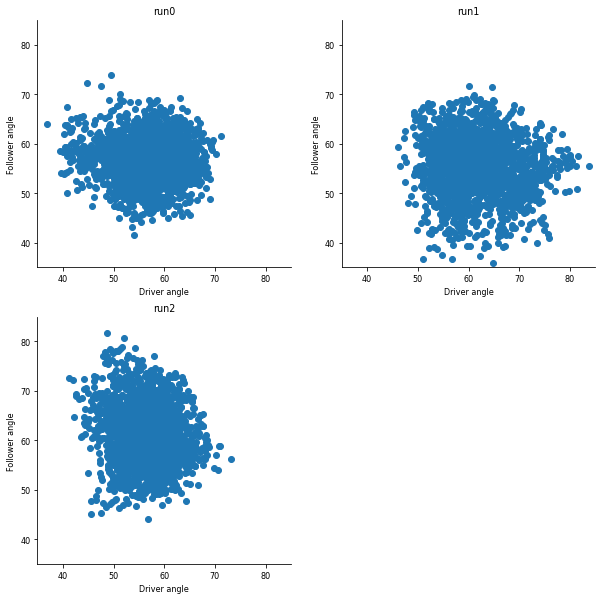

In [27]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))
for i, (d, f) in enumerate(zip(df['driver']['data'], df['follower']['data'])):
    x = int(np.floor(i/len(axs[0])))
    y = i%len(axs[0])
    ax[x][y].scatter(d, f)
    ax[x][y].set_xlim((35, 85))
    ax[x][y].set_ylim((35, 85))
    ax[x][y].set_title('run{}'.format(i))
    ax[x][y].set_xlabel('Driver angle')
    ax[x][y].set_ylabel('Follower angle')
    ax[x][y].spines['top'].set_visible(False)
    ax[x][y].spines['right'].set_visible(False)
    
ax[1][1].set_axis_off()

In [28]:
'''from json import dump
data = {
    'driver' : df['driver']['data'][0].tolist(),
    'follower' : df['follower']['data'][0].tolist()
}
with open('../data/d_f_op.json', 'w+') as f:
    dump(data, f)'''
#print(df['driver']['data'][0][92], df['follower']['data'][0][92])

"from json import dump\ndata = {\n    'driver' : df['driver']['data'][0].tolist(),\n    'follower' : df['follower']['data'][0].tolist()\n}\nwith open('../data/d_f_op.json', 'w+') as f:\n    dump(data, f)"

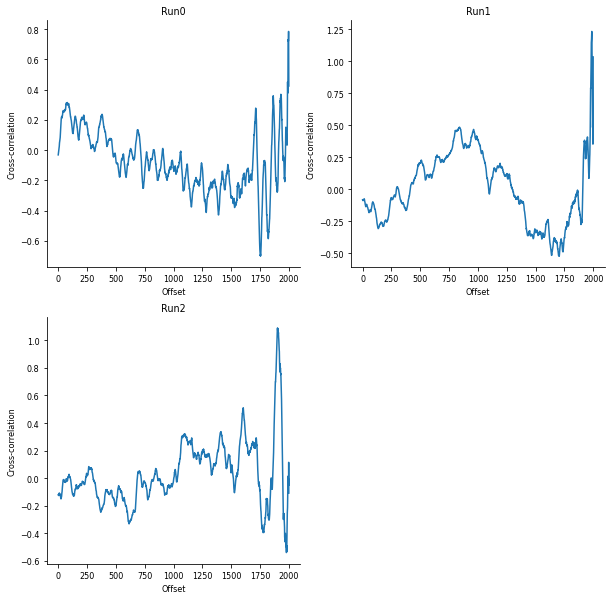

In [29]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))
for i, (d, f) in enumerate(zip(df['driver']['data'], df['follower']['data'])):
    x = int(np.floor(i/len(axs[0])))
    y = i%len(axs[0])
    
    c = sm.tsa.ccf(d, f, adjusted=True)
    ax[x][y].plot(c)
    ax[x][y].set_xlabel('Offset')
    ax[x][y].set_ylabel('Cross-correlation')
    ax[x][y].spines['top'].set_visible(False)
    ax[x][y].spines['right'].set_visible(False)
    ax[x][y].set_title('Run{}'.format(i))
    
ax[1][1].set_axis_off()

58.161199629526514
6.201623851995546

57.77027052398967
6.0437846477046095


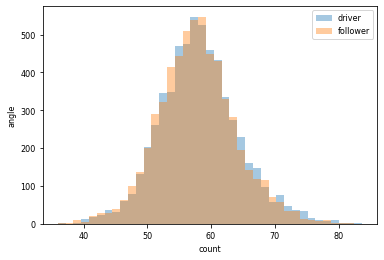

In [30]:
fig, ax = plt.subplots()
all_driver = np.array([])
all_follower = np.array([])
for d, f in zip(df['driver']['data'], df['follower']['data']):
    all_driver = np.concatenate((all_driver, d), axis=None)
    all_follower = np.concatenate((all_follower, f), axis=None)
    
print(np.mean(all_driver))
print(np.std(all_driver))
print()
print(np.mean(all_follower))
print(np.std(all_follower))

bins = np.linspace(min(min(all_driver), min(all_follower)), max(max(all_driver), max(all_follower)), 40)

ax.hist(all_driver, bins, alpha=0.4, label='driver')
ax.hist(all_follower, bins, alpha=0.4, label='follower')
ax.set_xlabel('count')
ax.set_ylabel('angle')
plt.legend()

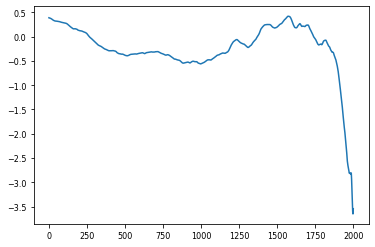

In [31]:

d = df['driver_pull16_fine']['data'][1]
f = df['follower_pull16_fine']['data'][1]
c = sm.tsa.ccf(d, f)

fig, ax = plt.subplots()
ax.plot(c)

In [32]:
distance_matrix = []
for d in df:
    avg_difference = 0
    for i, v1 in enumerate(df[d]['mean']):
        for j, v2 in enumerate(df[d]['mean'][i+1:]):
            avg_difference += (v1-v2)
    print(d, avg_difference/len(df[d]['mean']))
    
    #for d2 in df:
    #    distance_matrix.append(

NE_23 2.800789173892236
NE_37 -1.2237387085854532
NE_NB_23 10.692258278990147
NE_NB_37 2.3627252746752183
NE_NB_release_fine_23 26.344914827607006
NE_NB_release_fine_37 1.5134920319404244
NE_NS_23 -0.026316911984650915
NE_NS_37 2.0427670707659993
NE_NS_NB_23 1.5685208925327554
NE_NS_NB_37 -0.7520679327075092
NE_NS_NB_release_fine_23 20.119094713074215
NE_NS_NB_release_fine_23_2 2.1684682848808117
NE_NS_NB_release_fine_37 -5.557959576857133
NE_NS_pull16_fine_23 10.099766951992567
NE_NS_pull16_fine_37 5.6116360440547
NE_NS_release_fine_23 23.44631633224642
NE_NS_release_fine_37 3.0290356333192845
NE_pull16_fine_37 -5.2490229278749805
NE_pull16_fine_diff_start_23 5.458678549893961
NE_pull16_fine_same_start_23 9.867150641863493
NE_release_fine_37 12.963922065124724
NE_release_fine_diff_start_23 2.3411983819522235
NE_release_fine_same_start_23 -2.725490998608614
driver_NB_release_fine -4.6382489985395186
driver 0.047043252376577506
driver_pull16_fine 1.2901158841487508
driver_release_fine 2

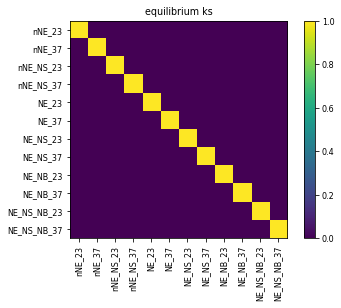

/home/erik/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: p-value capped: true value larger than 0.25
/home/erik/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: p-value floored: true value smaller than 0.001


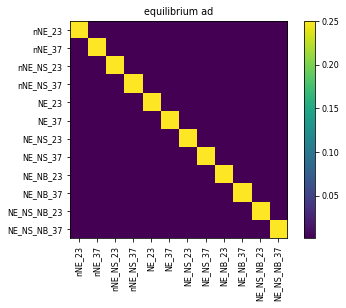

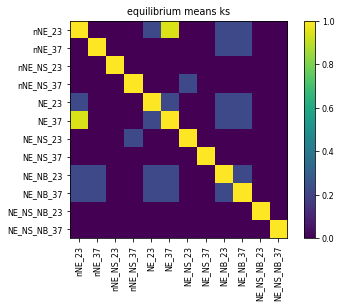

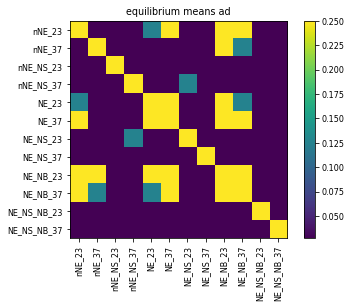

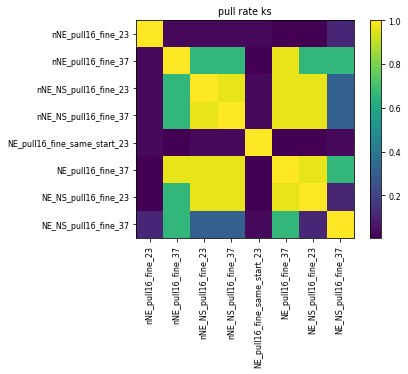

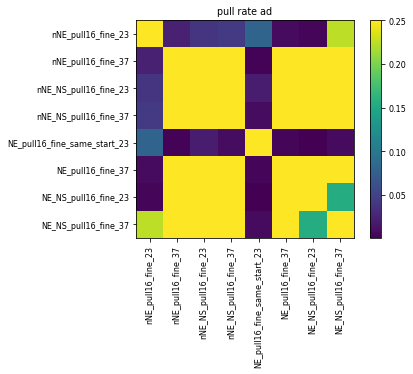

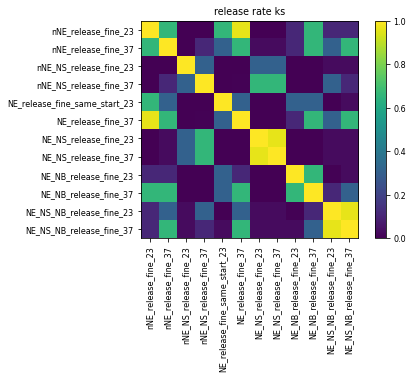

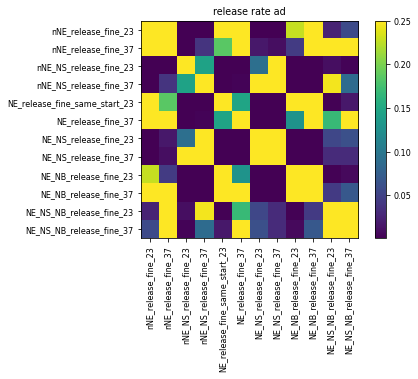

In [33]:
def make_sig_plot(data, title, labels):
    plt.clf()
    plt.imshow(data)
    plt.colorbar()
    plt.xticks(np.arange(len(labels)), labels, rotation='vertical')
    plt.yticks(np.arange(len(labels)), labels)
    plt.title(title)
    plt.show()

# Create combined distribution of equilibriums
munge_zone = []
for i, d in enumerate(plot_37.keys()):
    munge2 = []
    for j in range(3):
        munge2.append(df[d]['data'][j])
    munge_zone.append(np.concatenate(munge2).ravel())
    
get_significance_ks = lambda d : [ks_2samp(a, b, mode='asymp')[1] for a in d for b in d]
get_significance_ad = lambda d : [anderson_ksamp([a, b]).significance_level for a in d for b in d]

sigs1 = np.array(get_significance_ks(munge_zone))
sigs1 = sigs1.reshape(len(munge_zone), len(munge_zone))
labels = plot_37.keys()
make_sig_plot(sigs1, 'equilibrium ks', labels)

sigs2 = np.array(get_significance_ad(munge_zone))
sigs2 = sigs2.reshape(len(munge_zone), len(munge_zone))
make_sig_plot(sigs2, 'equilibrium ad', labels)

#Compare distribution of means from equilibriums
munge_zone = []
for i, d in enumerate(plot_37.keys()):
    munge_zone.append(df[d]['mean'])

sigs1 = np.array(get_significance_ks(munge_zone))
sigs1 = sigs1.reshape(len(munge_zone), len(munge_zone))
make_sig_plot(sigs1, 'equilibrium means ks', labels)

sigs2 = np.array(get_significance_ad(munge_zone))
sigs2 = sigs2.reshape(len(munge_zone), len(munge_zone))
make_sig_plot(sigs2, 'equilibrium means ad', labels)

# Compare distribution of rates from pulls
munge_zone = []
for i, d in enumerate(pull_37.keys()):
    munge_zone.append(df[d]['rate'])

labels = pull_37.keys()
sigs1 = np.array(get_significance_ks(munge_zone))
sigs1 = sigs1.reshape(len(munge_zone), len(munge_zone))
make_sig_plot(sigs1, 'pull rate ks', labels)

sigs2 = np.array(get_significance_ad(munge_zone))
sigs2 = sigs2.reshape(len(munge_zone), len(munge_zone))
make_sig_plot(sigs2, 'pull rate ad', labels)


# Compare distribution of rates from releases
munge_zone = []
for i, d in enumerate(release_37.keys()):
    munge_zone.append(df[d]['rate'])

labels = release_37.keys()
sigs1 = np.array(get_significance_ks(munge_zone))
sigs1 = sigs1.reshape(len(munge_zone), len(munge_zone))
make_sig_plot(sigs1, 'release rate ks', labels)

sigs2 = np.array(get_significance_ad(munge_zone))
sigs2 = sigs2.reshape(len(munge_zone), len(munge_zone))
make_sig_plot(sigs2, 'release rate ad', labels)

In [34]:
mean_NE_NS_NB_37 = np.mean([78.77,80.66,79.9])
var_NE_NS_NB_37 = np.sqrt(np.mean([88.33,66.63,70.18]))
print(mean_NE_NS_NB_37)
print(var_NE_NS_NB_37)

mean_NE_NB_37 = np.mean([56.21, 57.42, 52.67])
print(mean_NE_NB_37)

mean_nNE_37 = np.mean([59.0,56.22,59.98])
print(mean_NE_NB_37)

79.77666666666667
8.662947920117416
55.43333333333334
55.43333333333334


In [35]:
munge_zone = []
names = []
for d in df:
    munge2 = []
    for j in range(len(df[d]['data'])):
        munge2.append(df[d]['data'][j])
    munge_zone.append(np.concatenate(munge2).ravel())
    names.append(d)
    
print('name\tmean\tstdev\tmedian\tq1\tq3')
for m,n in zip(munge_zone, names):
    if n == 'NE_NB_23' or n == 'NE_NB_37' or n =='nNE_23' or n == 'nNE_37' or n == 'NE_23' or n == 'NE_37':
        print(n, end='\t')
        print("{:.4}".format(np.mean(m)), end='\t')
        print("{:.4}".format(np.std(m)), end='\t')
        print("{:.4}".format(np.median(m)), end='\t')
        print("{:.4}".format(str(np.percentile(m, 25))), end='\t')
        print("{:.4}".format(str(np.percentile(m, 75))))

name	mean	stdev	median	q1	q3
NE_23	49.31	7.878	49.16	43.5	54.8
NE_37	53.6	7.497	53.49	48.6	58.6
NE_NB_23	47.02	12.07	46.4	37.6	56.2
NE_NB_37	55.42	7.983	55.62	49.9	60.9
nNE_23	54.49	6.382	54.35	50.1	58.6
nNE_37	58.4	7.201	58.42	53.6	63.2


In [36]:
print("nNE")
print(np.mean(df['nNE_pull16_fine_37']['rate']))
print(np.mean(df['nNE_release_fine_37']['rate']))
print(np.std(df['nNE_pull16_fine_37']['rate']))
print(np.std(df['nNE_release_fine_37']['rate']))

print("nNE_NS")
print(np.mean(df['nNE_NS_pull16_fine_37']['rate']))
print(np.mean(df['nNE_NS_release_fine_37']['rate']))
print(np.std(df['nNE_NS_pull16_fine_37']['rate']))
print(np.std(df['nNE_NS_release_fine_37']['rate']))

print("NE_NB")
print(np.mean(df['NE_NB_release_fine_37']['rate']))
print(np.std(df['NE_NB_release_fine_37']['rate']))

print("NE_NS_NB")
print(np.mean(df['NE_NS_NB_release_fine_37']['rate']))
print(np.std(df['NE_NS_NB_release_fine_37']['rate']))

print("NE")
print(np.mean(df['NE_pull16_fine_37']['rate']))
print(np.mean(df['NE_release_fine_37']['rate']))
print(np.std(df['NE_pull16_fine_37']['rate']))
print(np.std(df['NE_release_fine_37']['rate']))

print("NE_NS")
print(np.mean(df['NE_NS_pull16_fine_37']['rate']))
print(np.mean(df['NE_NS_release_fine_37']['rate']))
print(np.std(df['NE_NS_pull16_fine_37']['rate']))
print(np.std(df['NE_NS_release_fine_37']['rate']))

print("driver")
print(np.mean(df['driver_pull16_fine']['rate']))
print(np.mean(df['driver_release_fine']['rate']))
print(np.std(df['driver_pull16_fine']['rate']))
print(np.std(df['driver_release_fine']['rate']))

print("follower")
print(np.mean(df['follower_pull16_fine']['rate']))
print(np.mean(df['follower_release_fine']['rate']))
print(np.std(df['follower_pull16_fine']['rate']))
print(np.std(df['follower_release_fine']['rate']))

nNE
-0.27950351505107573
0.12657440586299018
0.06988563836060727
0.06157143249984921
nNE_NS
-0.2929619134490592
0.21048941641285182
0.10402734310257597
0.06794522617493867
NE_NB
0.0846271941303208
0.07041271702096775
NE_NS_NB
0.15245962871805052
0.06067086569180551
NE
-0.28014720954608285
0.11177432839892368
0.10037505320344171
0.05180380974127991
NE_NS
-0.2609360451830201
0.21838179325360363
0.08018908052764755
0.045141969650470445
driver
-0.08194466440941864
0.09150722893465749
0.057035454932032374
0.02884027631740088
follower
-0.11414804738769721
0.07667560685809031
0.05769235051480706
0.04499023023719157


In [37]:
#write out all the data as a csv for mathias
#numpy.savetxt("foo.csv", a, delimiter=",")
#df.loc['data'].index

#df.loc['data'][0]]
from sys import maxsize
np.set_printoptions(threshold=maxsize)
with open('../data/combined_data.csv', 'w') as f:
    for i, d in zip(df.loc['data'].index, df.loc['data']):
        for j in range(len(d)):
            f.write("{}_{},{}\n".format(i, j, np.array2string(d[j], separator=',').strip('[]')))


Loose
0.4561666666666667
0.014504788481356364
linked
0.5493333333333333
0.007542472332656513
name	mean	stdev	median	q1	q3
NAME,7.938,2.675,7.8,5.98,9.72
NAME,7.312,2.453,7.185,5.54,8.95


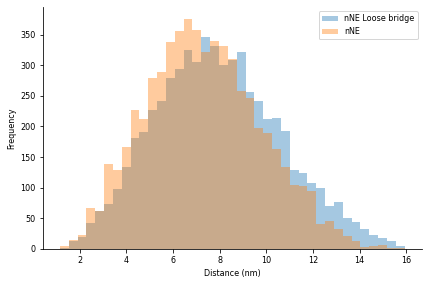

In [38]:
with open('../distance/loose_linked_distance') as f:
    data = f.readlines()
    
loose = []
linked = []

loose1 = []
loose2 = []
loose3 = []

linked1 = []
linked2 = []
linked3 = []

for l in data[1:]:
    l = l.split('\t')
    loose.append(float(l[0]))
    loose.append(float(l[1]))
    loose.append(float(l[2]))
    
    loose1.append(float(l[0]))
    loose2.append(float(l[1]))
    loose3.append(float(l[2]))
    
    linked.append(float(l[3]))
    linked.append(float(l[4]))
    linked.append(float(l[5]))
    
    linked1.append(float(l[3]))
    linked2.append(float(l[4]))
    linked3.append(float(l[5]))
    
loose = np.array(loose)
loose1 = np.array(loose1)
loose2 = np.array(loose2)
loose3 = np.array(loose3)
linked = np.array(linked)
linked1 = np.array(linked1)
linked2 = np.array(linked2)
linked3 = np.array(linked3)

loose_above = loose > 7.5
loose1_above = loose1 > 7.5
loose2_above = loose2 > 7.5
loose3_above = loose3 > 7.5
linked_above = linked > 7.5
linked1_above = linked1 > 7.5
linked2_above = linked2 > 7.5
linked3_above = linked3 > 7.5

loose1_mean = 1-sum(loose1_above)/len(loose1)
loose2_mean = 1-sum(loose2_above)/len(loose2)
loose3_mean = 1-sum(loose3_above)/len(loose3)
linked1_mean = 1-sum(linked1_above)/len(linked1)
linked2_mean = 1-sum(linked2_above)/len(linked2)
linked3_mean = 1-sum(linked3_above)/len(linked3)

print("Loose")
print(1-sum(loose_above)/len(loose))
print(np.std([loose1_mean, loose2_mean, loose3_mean]))
print("linked")
print(1-sum(linked_above)/len(linked))
print(np.std([linked1_mean, linked2_mean, linked3_mean]))

print('name\tmean\tstdev\tmedian\tq1\tq3')
for ds in [loose, linked]:
    print('NAME', end=',')
    print("{:.4}".format(np.mean(ds)), end=',')
    print("{:.4}".format(np.std(ds)), end=',')
    print("{:.4}".format(np.median(ds)), end=',')
    print("{:.4}".format(str(np.percentile(ds, 25))), end=',')
    print("{:.4}".format(str(np.percentile(ds, 75))))
    
fig, ax = plt.subplots()
bins = np.linspace(min(linked), max(linked), 40)
ax.hist(loose, bins, alpha = 0.4, label='nNE Loose bridge')
ax.hist(linked, bins, alpha = 0.4, label='nNE')
ax.set_xlabel("Distance (nm)")
ax.set_ylabel("Frequency")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend()
plt.tight_layout()
plt.show()

In [39]:
files = [f for f in listdir('../bonds/') if f.split('.')[1] == 'txt']
files.sort()

name_change = {
    'linked23' : 'nNE_23',
    'linked37' : 'nNE_37',
    'pull23' : 'nNE_pull16_fine_23',
    'pull37' : 'nNE_pull16_fine_37',
    'release23' : 'nNE_release_fine_23',
    'release37' : 'nNE_release_fine_37',
    'stiff23' : 'NE_23',
    'stiff37' : 'NE_37',
    'stiff_pull23' : 'NE_pull16_fine_same_start_23',
    'stiff_pull37' : 'NE_pull16_fine_37',
    'stiff_release23' : 'NE_release_fine_same_start_23',
    'stiff_release37' : 'NE_release_fine_37'
}

bonds = {}

for bondfile in files:
    with open('../bonds/'+bondfile) as f:
        bonds[name_change[bondfile.split('_bonds')[0]]] = [np.array(l.strip().split(' '), dtype='float') for l in f.readlines()]

63.77054166666667
48.8383446969697


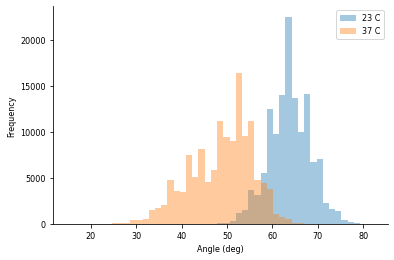

In [40]:
fig, ax = plt.subplots()
bonds_23 = []
bonds_37 = []
for name in filter(lambda k :'23' in k, bonds):
    for ds in bonds[name]:
        bonds_23.extend(ds)
        
for name in filter(lambda k :'37' in k, bonds):
    for ds in bonds[name]:
        bonds_37.extend(ds)
        
print(np.mean(bonds_23))
print(np.mean(bonds_37))
    
bins = np.linspace(min(bonds_37), max(bonds_23), 50)
ax.hist(bonds_23, bins, label='23 C', alpha=0.4)
ax.hist(bonds_37, bins, label='37 C', alpha=0.4)
ax.set_xlabel("Angle (deg)")
ax.set_ylabel("Frequency")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend()
plt.show()

In [41]:
diff_pull23 = []
diff_pull37 = []
diff_release23 = []
diff_release37 = []
for name in filter(lambda k :'23' in k and 'pull' in k, bonds):
    for ds in bonds[name]:
        diff_pull23.append(ds[-1] - ds[0])
        
for name in filter(lambda k :'37' in k and 'pull' in k, bonds):
    for ds in bonds[name]:
        diff_pull37.append(ds[-1] - ds[0])    
        
for name in filter(lambda k :'23' in k and 'release' in k, bonds):
    for ds in bonds[name]:
        diff_release23.append(ds[-1] - ds[0])
        
for name in filter(lambda k :'37' in k and 'release' in k, bonds):
    for ds in bonds[name]:
        diff_release37.append(ds[-1] - ds[0])
        
print(np.mean(diff_pull23), np.std(diff_pull23))
print(np.mean(diff_pull37), np.std(diff_pull37))
print(np.mean(diff_release23), np.std(diff_release23))
print(np.mean(diff_release37), np.std(diff_release37))

-0.8 3.2916561181265576
0.525 3.98269695056001
-0.95 5.467860641969581
-0.3 6.435060217278468


In [42]:
for name in filter(lambda k :'23' in k and 'pull' in k, bonds):
    print(bonds[name][0][-1])
    

for name in filter(lambda k :'23' in k and 'release' in k, bonds):
    print(bonds[name][0][0])

65.0
61.5
63.0
66.0


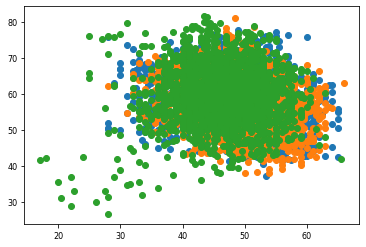

In [43]:
fig, ax = plt.subplots()
[ax.scatter(x, y, label=i) for i, (x, y) in enumerate(zip(bonds['nNE_37'],df['nNE_37']['data']))]
plt.show()

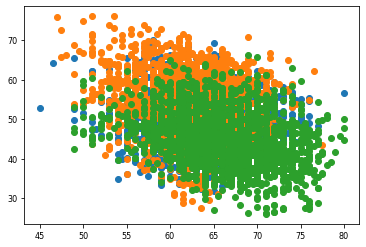

In [44]:
fig, ax = plt.subplots()
[ax.scatter(x, y, label=i) for i, (x, y) in enumerate(zip(bonds['NE_23'],df['NE_23']['data']))]
plt.show()

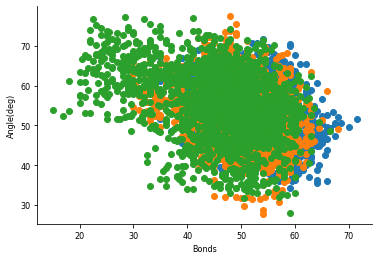

In [45]:
fig, ax = plt.subplots()
[ax.scatter(x, y, label=i) for i, (x, y) in enumerate(zip(bonds['NE_37'],df['NE_37']['data']))]
ax.set_xlabel("Bonds")
ax.set_ylabel("Angle(deg)")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

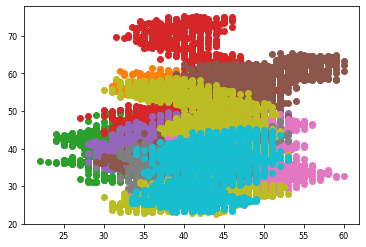

In [46]:
fig, ax = plt.subplots()
[ax.scatter(x, y, label=i) for i, (x, y) in enumerate(zip(bonds['nNE_release_fine_37'],df['nNE_release_fine_37']['data']))]
plt.show()

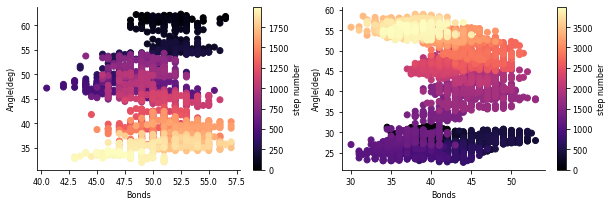

In [47]:
fig, ax = plt.subplots(1,2, figsize=(10, 3))
color_idx = np.arange(len(bonds['nNE_release_fine_37'][8]))
a = ax[1].scatter(bonds['nNE_release_fine_37'][8], df['nNE_release_fine_37']['data'][8],c=color_idx, cmap='magma')
plt.colorbar(a, ax=ax[1], label='step number')
ax[1].set_xlabel("Bonds")
ax[1].set_ylabel("Angle(deg)")
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)

color_idx = np.arange(len(bonds['NE_37'][2]))
a2 = ax[0].scatter(bonds['nNE_pull16_fine_37'][2],df['nNE_pull16_fine_37']['data'][2], c=color_idx, cmap='magma')
plt.colorbar(a2, ax=ax[0], label='step number')
ax[0].set_xlabel("Bonds")
ax[0].set_ylabel("Angle(deg)")
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)